This notebook contains the code to generate the plots shown in the paper. It assumes the experiments were run as described on GitHub, and the result are stored in /experiments.

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from SOC_eigf.experiment_settings.settings import define_variables
from SOC_eigf.utils import stochastic_trajectories, control_objective
from SOC_eigf.method import SOC_Solver

### Exact solution

In [2]:
cfg = OmegaConf.load('experiment_cfg.yaml')
cfg.setting = "OU_quadratic_hard"
cfg.d = 20
cfg.T = 4.0
ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)
x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
optimal_sde.use_learned_control = False

In [3]:
state0 = x0.repeat(cfg.optim.batch_size, 1)
states,_,_,_,_,target_controls = stochastic_trajectories(
                            optimal_sde,
                            state0,
                            ts.to(state0),
                            cfg.lmbd,
                            detach=True)

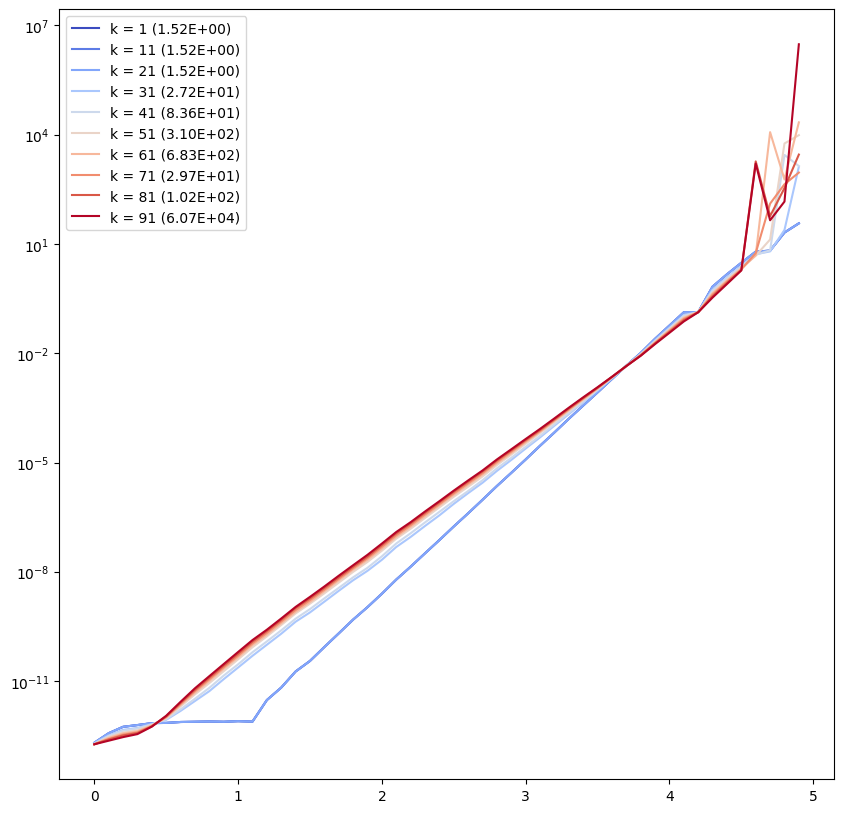

In [ ]:
gs_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], 1)

fig, ax = plt.subplots(figsize=(10,10))
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

max_k = 50
step = 10
ks = np.arange(1,max_k,step)
colors = [colormap(i / (len(ks) - 1)) for i in range(len(ks))]

for i in range(len(ks)):
    eigf_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], ks[i], verbose=False)
    err = ((eigf_controls - target_controls)**2).sum(dim=2).mean(dim=1).cpu()
    ax.plot(ts[:-1].cpu(), err, color = colors[i], label=f'k = {ks[i]} ({err.mean():.2E})')
    ax.set_yscale('log')

#ax.plot(ts.cpu(),(-(cfg.T - ts) * 7 * cfg.lmbd).exp().cpu(),color='black', ls='--')
ax.legend()
plt.show()

### Architecture

#### Relative vs absolute PINN loss

In [24]:
experiment_name = "OU_stable_d20"
run_names = ['var','ritz','pinn','rel']

In [25]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)


Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss', 'eigf_error',
       'grad_log_eigf_error', 'control_l2_error', 'run_name', 'time',
       'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA', 'eigf_error_EMA',
       'grad_log_eigf_error_EMA', 'control_l2_error_EMA'],
      dtype='object')


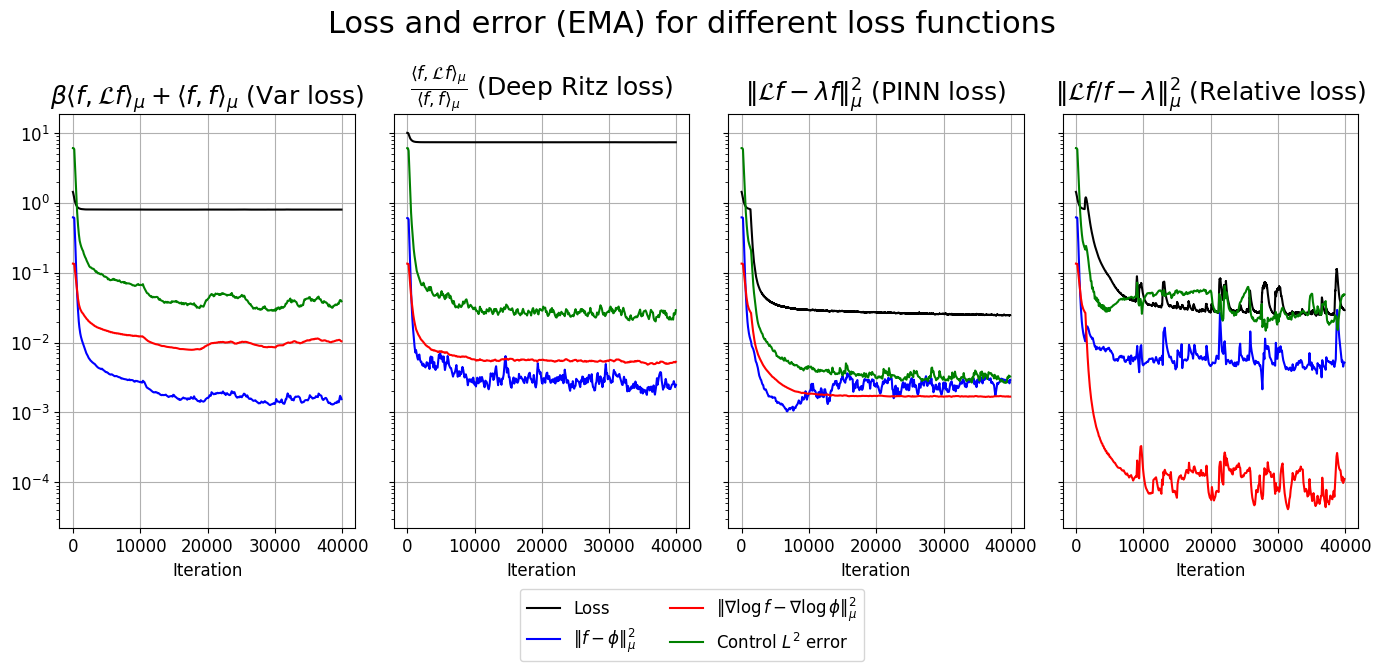

In [26]:
with plt.rc_context({'font.size': 12}):
    fig, axes = plt.subplots(1, len(run_names), figsize=(14,6),sharey=True,sharex=True)  # 1 row, 2 columns

    index = 'itr'
    col_appendix = "_EMA"
    labels = {
        'var': r'$\beta\langle f, \mathcal{L}f\rangle_\mu + \langle f, f\rangle_\mu$ (Var loss)',
        'ritz': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'pinn': r'$\|\mathcal{L}f-\lambda f\|_\mu^2$ (PINN loss)',
        'rel': r'$\|\mathcal{L}f/f-\lambda\|_\mu^2$ (Relative loss)',
    }

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='loss'+col_appendix, color='black', ax = axes[i],label='Loss')
        run_df.plot(x=index,y='eigf_error'+col_appendix, color='blue', ax = axes[i],label=r"$\|f-\phi\|_{\mu}^2$")
        run_df.plot(x=index,y='grad_log_eigf_error'+col_appendix, color='red', ax = axes[i],label=r"$\|\nabla\log f-\nabla \log\phi\|_{\mu}^2$")
        run_df.plot(x=index,y='control_l2_error'+col_appendix, color='green', ax = axes[i],label=r"Control $L^2$ error")

        #ax[i].set_title("$\|f-\phi\|_{\mu}^2$")
        axes[i].set_title(labels[run_names[i]],fontsize=18)
        axes[i].set_yscale('log')
        axes[i].grid()
        axes[i].set_xlabel('Time (s)' if index=="time" else "Iteration")
        #axes[i].set_xlim(0,80000)

    for ax in axes:
        ax.legend().set_visible(False)

    # Create shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.12))
    plt.suptitle('Loss and error (EMA) for different loss functions',fontsize=22)

    plt.tight_layout()
    plt.show()

#### Trajectory PINN loss vs equilibrium PINN loss

In [1]:
experiment_name = "OU_stable_d20"
run_names = ['rel_trajectory', 'rel_no_trajectory']

In [2]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 20
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

NameError: name 'pd' is not defined

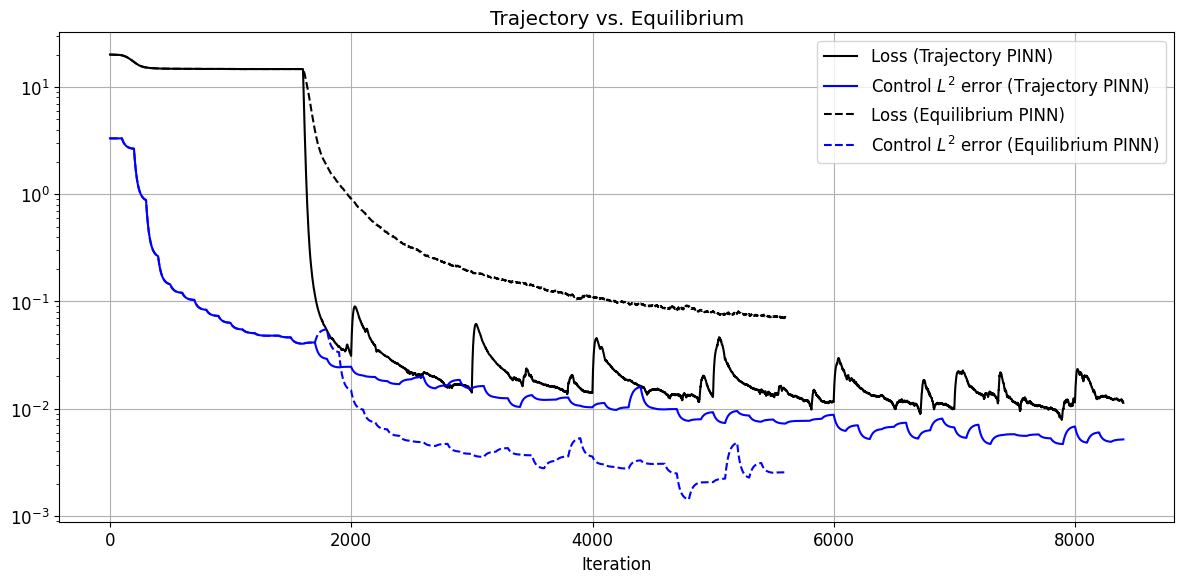

In [ ]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(12,6))

    index = 'itr'
    col_appendix = "_EMA"
    labels = {
        'rel_trajectory': "Trajectory PINN",
        'rel_no_trajectory': "Equilibrium PINN"
    }
    ls = {
        'rel_trajectory': '-',
        'rel_no_trajectory': '--'
    }

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='loss'+col_appendix, color='black', ax = ax, label=f'Loss ({labels[run_names[i]]})', ls = ls[run_names[i]])
        run_df.plot(x=index,y='control_l2_error'+col_appendix, color='blue', ax = ax, label=f'Control $L^2$ error ({labels[run_names[i]]})', ls = ls[run_names[i]])

        ax.set_yscale('log')
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")

    plt.legend()
    ax.set_title('Trajectory vs. Equilibrium')

    plt.tight_layout()
    plt.show()

#### UNet vs MLP

In [46]:
experiment_name = "OU_repulsive_d20"
run_names = ['EIGF/ritz_GELU',"EIGF/var_GELU"]

In [47]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

/tmp/ipykernel_3036307/4075749532.py:17: RuntimeWarning: divide by zero encountered in log
  .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))


Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss', 'es_loss',
       'es_main_loss', 'es_orth_loss', 'eigf_error', 'grad_log_eigf_error',
       'control_objective_mean', 'control_objective_std', 'control_l2_error',
       'run_name', 'time', 'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA',
       'es_loss_EMA', 'es_main_loss_EMA', 'es_orth_loss_EMA', 'eigf_error_EMA',
       'grad_log_eigf_error_EMA', 'control_l2_error_EMA'],
      dtype='object')


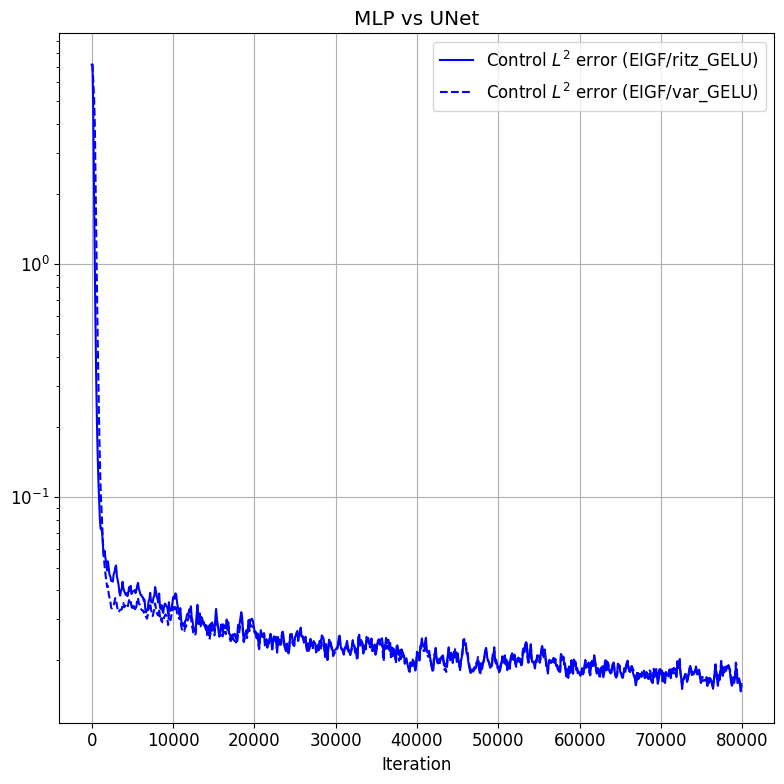

In [48]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    ls = ['-','--','-.']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        #run_df.plot(x=index,y='loss'+col_appendix, color='black', ax = ax, label=f'Loss ({run_names[i]})', ls = ls[i])
        run_df.plot(x=index,y='control_l2_error'+col_appendix, color='blue', ax = ax, label=f'Control $L^2$ error ({run_names[i]})', ls = ls[i])
        
        #run_df.plot(x=index,y='grad_log_eigf_error'+col_appendix, color='red', ax = ax, label=f'grad_log_eigf_error ({run_names[i]})', ls = ls[i])

        ax.set_yscale('log')
        #ax.set_xscale('log')
        #ax.set_xlim(100,)
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend(loc='upper right')
    ax.set_title('MLP vs UNet')

    plt.tight_layout()
    plt.show()

In [49]:
experiment_name = "ring_d2"
run_names = ['EIGF/rel_GAUSS',"EIGF/pinn_GAUSS","EIGF/var_GELU"]

In [52]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(np.clip(x,min=1e-8))).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss',
       'control_objective_mean', 'control_objective_std', 'run_name', 'time',
       'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA'],
      dtype='object')


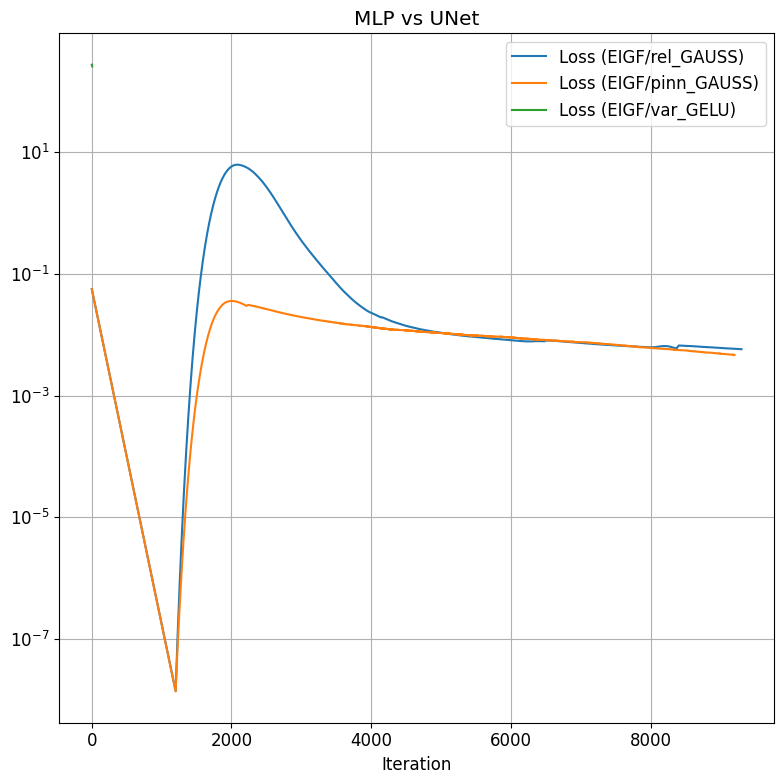

In [54]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    ls = ['-','--','-.']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"').query('loss > 0').query('itr>0').copy()
        run_df.plot(x=index,y='loss'+col_appendix, ax = ax, label=f'Loss ({run_names[i]})')
        
        ax.set_yscale('log')
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_xlim(0,100)
    plt.legend(loc='upper right')
    ax.set_title('MLP vs UNet')
    plt.tight_layout()
    plt.show()

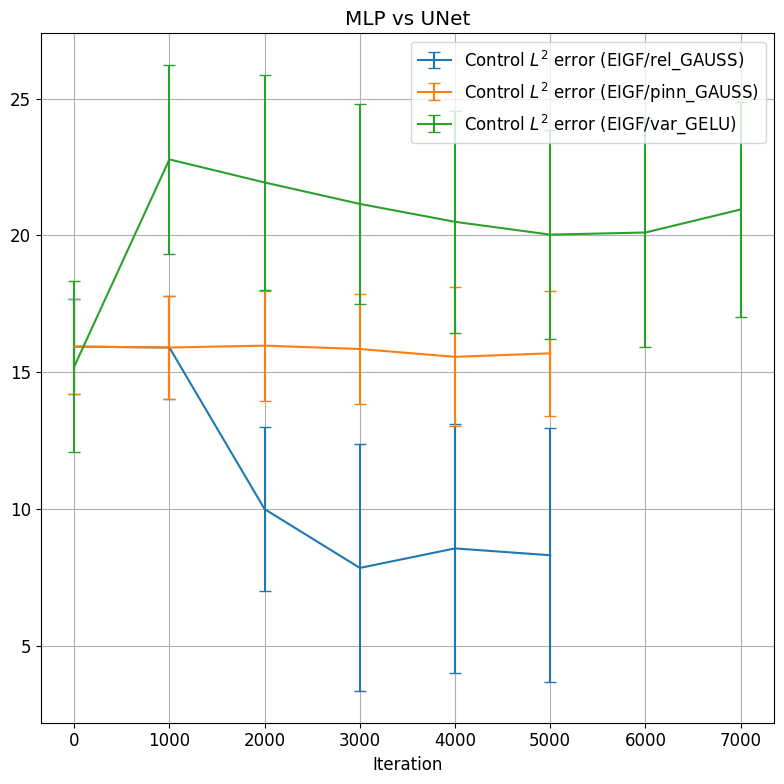

In [155]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = ""
    ls = ['-','--','-.']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"').copy()
        run_df.drop_duplicates('control_objective_mean',inplace=True)
        run_df.plot(x=index,y='control_objective_mean'+col_appendix, yerr='control_objective_std'+col_appendix, ax = ax, label=f'Control $L^2$ error ({run_names[i]})',capsize=4)
        
        #ax.set_xscale('log')
        #ax.set_xlim(100,)
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend(loc='upper right')
    ax.set_title('MLP vs UNet')

    plt.tight_layout()
    plt.show()

### Control error: IDO vs COMBINED

In [41]:
experiment_name = "OU_stable_d20"
run_names = ['IDO/rel_entropy','IDO/rel_entropy_2','COMBINED/rel_entropy_2','COMBINED/rel_entropy_adjSOCM']

Error vs iteration

In [42]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

Index(['itr', 'iteration_time', 'loss', 'control_l2_error', 'run_name', 'time',
       'control_objective_mean', 'control_objective_std', 'loss_EMA',
       'control_l2_error_EMA'],
      dtype='object')


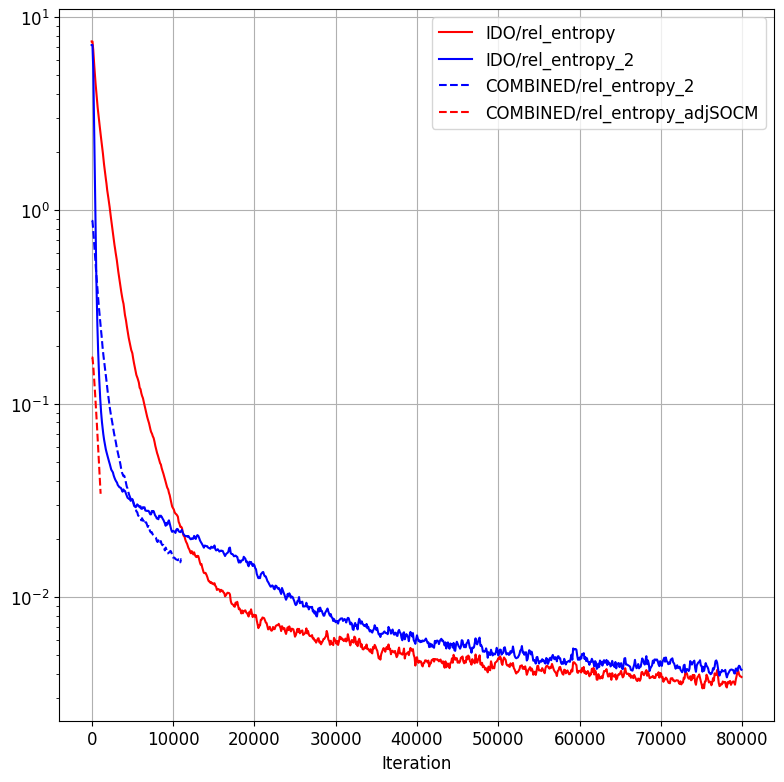

In [43]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    colors = []
    ls = []
    for run_name in run_names:
        if 'IDO' in run_name or 'EIGF' in run_name:
            ls += ['-']
        else:
            ls += ['--']
        
        if 'variance' in run_name or "rel_entropy_2" in run_name:
            colors += ['blue']
        elif 'rel_entropy' in run_name:
            colors += ['red']
        elif 'EIGF' in run_name:
            colors += ['black']


    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='control_l2_error'+col_appendix, color=colors[i], ax = ax, label=f'{run_names[i]}',ls=ls[i])

        ax.set_yscale('log')
        #ax.set_xscale('log')
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend()

    plt.tight_layout()
    plt.show()

Error vs. simulation time

/tmp/ipykernel_2920513/2214579498.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_names[i]}/solve


IDO/rel_entropy

IDO/rel_entropy_2
tensor([14.6887, 18.1726], device='cuda:0')
COMBINED/rel_entropy_2


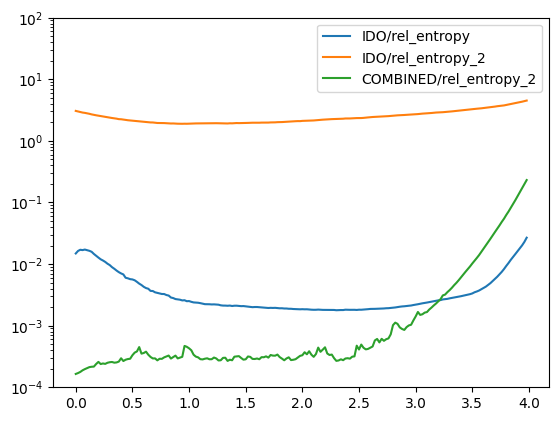

In [63]:
itrs = [75000,75000,10000]
for i in range(len(run_names)):
    cfg = OmegaConf.load(f'experiments/{experiment_name}/{run_names[i]}/cfg.yaml')
    cfg.T = 4.0
    cfg.num_steps=200
    ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)


    x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
    optimal_sde.use_learned_control = False

    state0 = x0.repeat(cfg.optim.batch_size*16, 1)
    
    if i == 0:
        states,_,_,_,_,target_control = stochastic_trajectories(
                                    optimal_sde,
                                    state0,
                                    ts.to(state0),
                                    cfg.lmbd,
                                    detach=True)

    solver = SOC_Solver(
            neural_sde,
            x0,
            None,
            T=cfg.T,
            num_steps=cfg.num_steps,
            lmbd=cfg.lmbd,
            d=cfg.d,
            sigma=sigma,
            solver_cfg=cfg.solver
        )

    solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_names[i]}/solver_weights_{itrs[i]:_}.pth'),strict=True)
    print(solver.neural_sde.eigvals if hasattr(solver.neural_sde, 'eigvals') else "")
    learned_control = solver.neural_sde.control(ts[:-1],states[:-1])
    norm_sqd_diff = torch.sum((target_control - learned_control) ** 2,dim=-1).mean(dim=1)
    print(run_names[i])
    plt.plot(ts[:-1].cpu(),norm_sqd_diff.detach().cpu(),label=run_names[i])
    

plt.yscale('log')
plt.ylim(1e-4,1e2)
plt.legend()
plt.show()

/tmp/ipykernel_2970900/3938622375.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_we

tensor(1.7420, device='cuda:0')
tensor(1.7420, device='cuda:0')
tensor(1.7420, device='cuda:0')


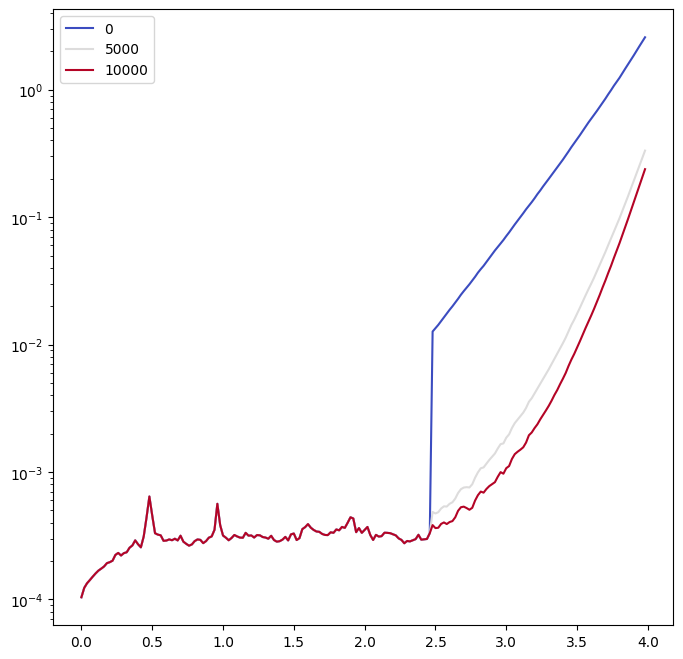

In [56]:
itrs = np.arange(3)*5000
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

colors = [colormap(i / (len(itrs) - 1)) for i in range(len(itrs))]

run_name = 'COMBINED/rel_entropy_2'
cfg = OmegaConf.load(f'experiments/{experiment_name}/{run_name}/cfg.yaml')
ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)

x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
optimal_sde.use_learned_control = False

state0 = x0.repeat(cfg.optim.batch_size*16, 1)

states,_,_,_,_,target_control = stochastic_trajectories(
                            optimal_sde,
                            state0,
                            ts.to(state0),
                            cfg.lmbd,
                            detach=True)

solver = SOC_Solver(
        neural_sde,
        x0,
        None,
        T=cfg.T,
        num_steps=cfg.num_steps,
        lmbd=cfg.lmbd,
        d=cfg.d,
        sigma=sigma,
        solver_cfg=cfg.solver
    )


fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(itrs)):
    solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_weights_{itrs[i]:_}.pth'),strict=True)
    learned_control = solver.neural_sde.control(ts[:-1],states[:-1])
    print(solver.neural_sde.eigval_diff)
    norm_sqd_diff = torch.sum((target_control - learned_control) ** 2,dim=-1).mean(dim=1)
    ax.plot(ts[:-1].cpu(),norm_sqd_diff.detach().cpu(),label=itrs[i],color=colors[i])
    

ax.set_yscale('log')
#ax.set_ylim(1e-4,1e2)
ax.legend()
plt.show()

In [59]:
experiment_name = 'ring_d2'
run_name = 'EIGF/rel_GAUSS'
cfg = OmegaConf.load(f'experiments/{experiment_name}/{run_name}/cfg.yaml')

cfg.num_steps=50
ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)

x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)

state0 = x0.repeat(cfg.optim.batch_size*16, 1)

solver = SOC_Solver(
        neural_sde,
        x0,
        None,
        T=cfg.T,
        num_steps=cfg.num_steps,
        lmbd=cfg.lmbd,
        d=cfg.d,
        sigma=sigma,
        solver_cfg=cfg.solver
    )

solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_weights_10_000.pth'))

/tmp/ipykernel_3036307/3060534616.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_name}/solver_we

<All keys matched successfully>

In [60]:
angles = torch.linspace(0,2*np.pi,len(ts),device=ts.device)
r_states = []
n = 3
rs = torch.linspace(4.5,5.5,n)
for r in rs:
    r_states.append(r/2**(1/2) * torch.stack([angles.cos(),angles.sin()],dim=1))

states = torch.concatenate(r_states)

controls = solver.control(torch.zeros(len(states),device=states.device), states)[:-1,:]
states= states.unsqueeze(1)
controls = controls.unsqueeze(1)

In [61]:
states = states[:-1].cpu().detach()
controls = controls.cpu().detach()

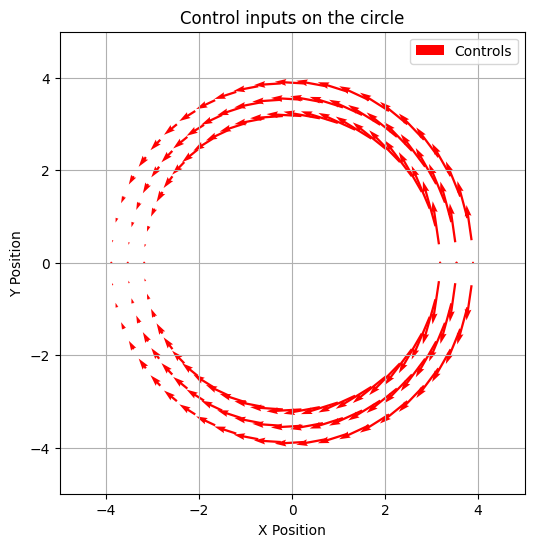

In [62]:
import matplotlib.cm as cm

i = 0
dt = (ts[1] - ts[0]).cpu()
# Extract the first batch for visualization
x, y = states[:, i, 0], states[:, i, 1]
u, v = controls[:, i, 0], controls[:, i, 1]

colors = cm.viridis(np.linspace(0, 1, len(x)))

# Adjusting the plot to be square with equal axis length
fig, ax = plt.subplots(figsize=(6, 6))  # Make the figure square

# Plot trajectory
#for i in range(len(x) - 1):
#    ax.plot([x[i], x[i+1]], [y[i], y[i+1]], color=colors[i], linewidth=2)
#sc = ax.scatter(x, y, c=np.arange(len(x)), cmap="viridis", edgecolors='k', zorder=3, label="State Trajectory")

    
# Plot control vectors as arrows
ax.quiver(x, y, u, v, angles='xy', scale_units='xy', color='r', alpha=1.0, scale=4.0, label="Controls")

# Labels and title
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Control inputs on the circle")

# Ensure equal aspect ratio
#ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

ax.legend()
ax.grid()
plt.show()

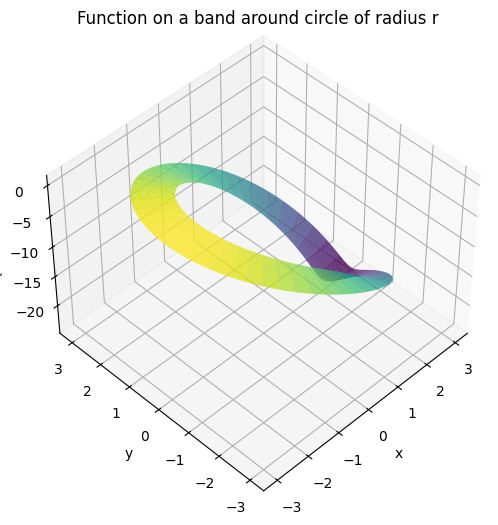

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example function: f(x, y) = sin(x^2 + y^2)
def f(x):
    return solver.neural_sde.eigf_gs_model(x)

# Parameters
r = 2.5         # Radius of the circle
delta = 0.5    # Half-width of the band
n_rho = 100      # Radial samples
n_theta = 200    # Angular samples

# Polar coordinates
rho = torch.linspace(r - delta, r + delta, n_rho,device=cfg.device)
theta = torch.linspace(0, 2 * np.pi, n_theta,device=cfg.device)
RHO, THETA = torch.meshgrid(rho, theta)

# Convert to Cartesian
X = RHO * torch.cos(THETA)
Y = RHO * torch.sin(THETA)
XY = torch.stack([X.ravel(), Y.ravel()], axis=1)  # shape (N, 2)
#Z = (-(-f(XY)).exp()).reshape(X.shape)  # Reshape back to (n_theta, n_rho)
Z = (-(-f(XY))).reshape(X.shape)  # Reshape back to (n_theta, n_rho)


# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.cpu(), Y.cpu(), Z.detach().cpu(), cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Function on a band around circle of radius r')

ax.view_init(45, 180+45)

plt.show()

